<a href="https://colab.research.google.com/github/udaykondreddy/toonify-yourself/blob/master/Toonify_yourself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toonify yourself!

Please ensure that you're using a GPU runtime

First some setup:

In [1]:
#For this demo we will be using tensorflow 1.x

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:

!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.31 MiB | 4.06 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/stylegan2
CPU says hello.
GPU says hello.


In [3]:
!mkdir raw
!mkdir aligned
!mkdir generated

## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)


In [4]:
%cd /content/stylegan2/raw

/content/stylegan2/raw


In [5]:
from google.colab import files
uploaded = files.upload()

Saving dhoniheadshot-min.jpg to dhoniheadshot-min.jpg


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
%cd /content/stylegan2

/content/stylegan2


In [9]:
import pretrained_networks

# Justin copy of the blended model https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU
# get the original (Doron) here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
# or take it from my google drive - https://drive.google.com/uc?id=1JmUASSm6kb9tXAIAk8BCKfgBP5M26FRv
# or use file path link after mounting your google drive
blended_url = "/content/gdrive/My Drive/ffhq-cartoon-blended-64.pkl" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [10]:
!python align_images.py raw aligned

64045056/64040097 [==============================] - 27s 0us/step


In [11]:
!python project_images.py --num-steps 500 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "dhoniheadshot-min_01.png"...


In [12]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


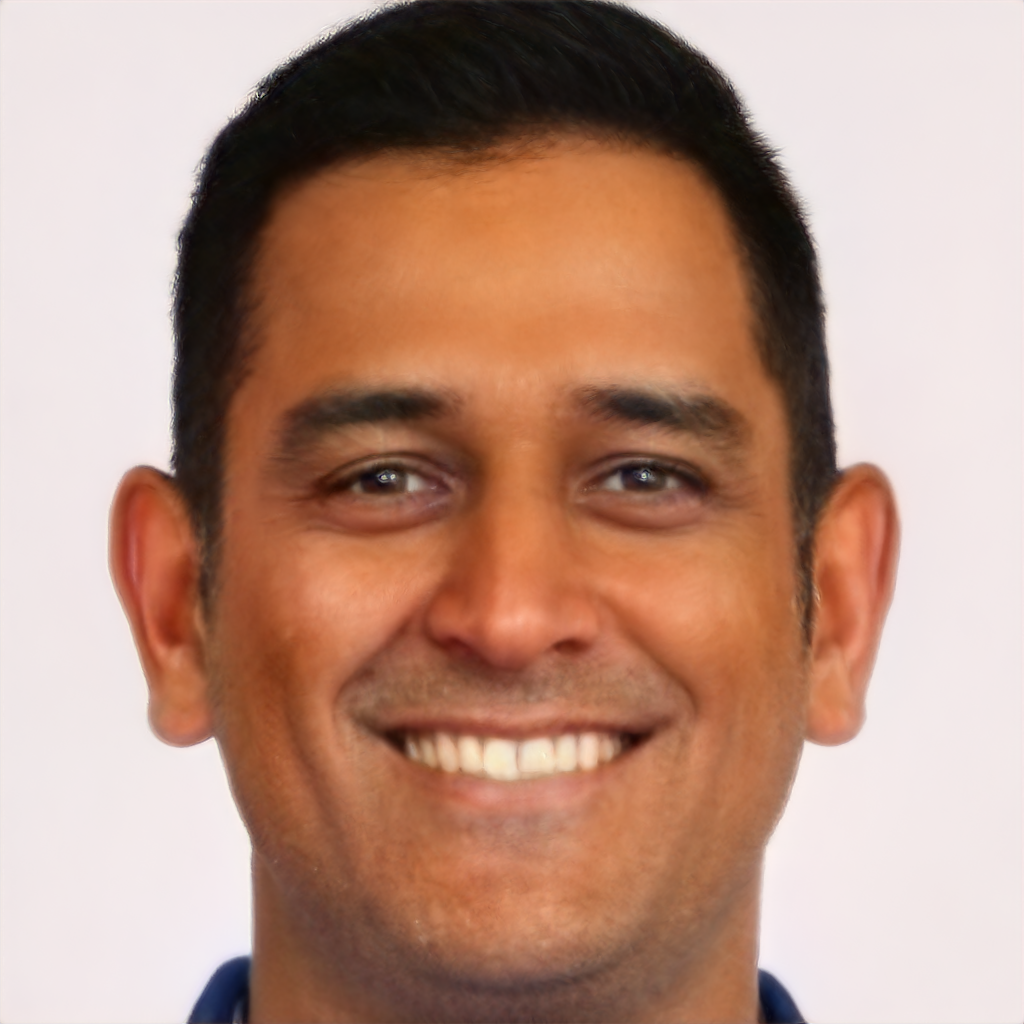

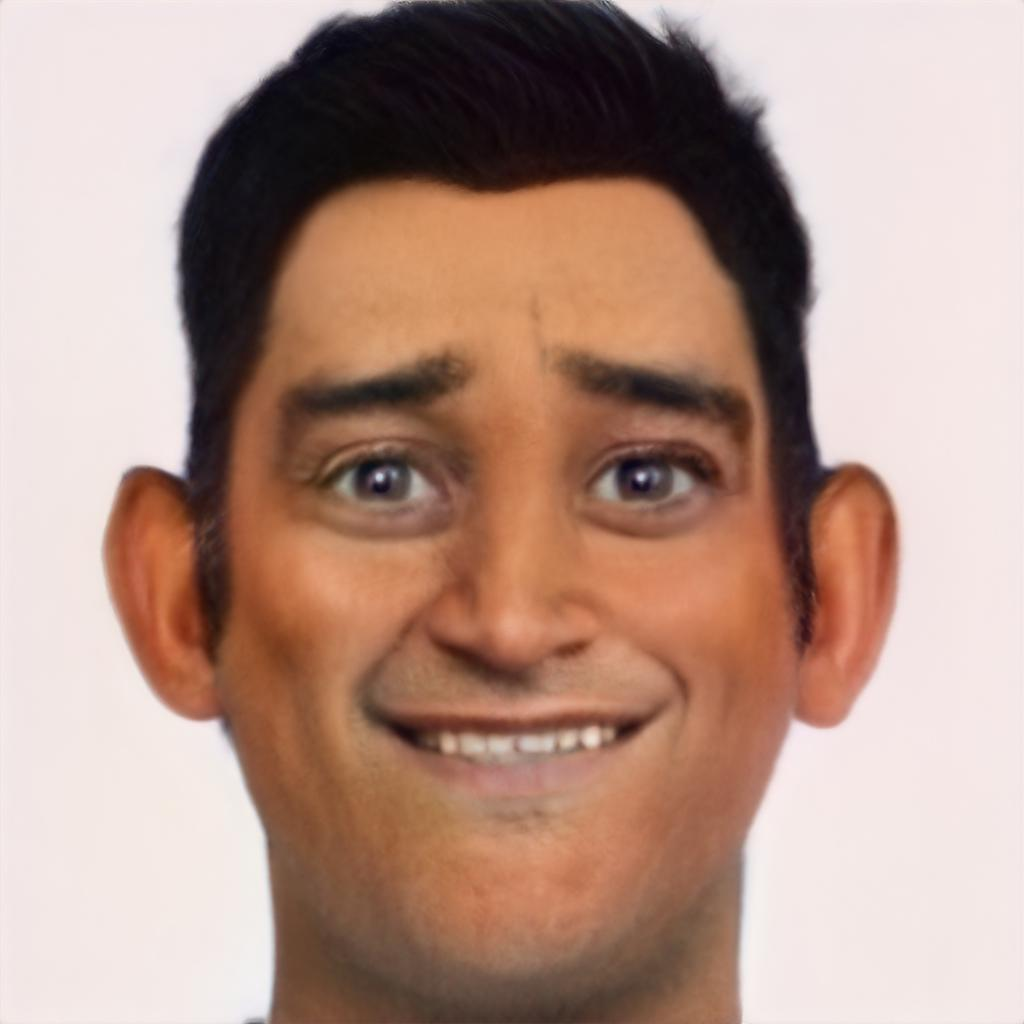

In [14]:
from IPython.display import Image 

def display_image(img):
  embedded = Image(filename="generated/"+img+"_01.png", width=256)
  display(embedded)
  tooned = Image(filename="generated/"+img+"_01-toon.jpg", width=256)
  display(tooned)

display_image(str("dhoniheadshot-min"))